# MaSim Analysis and Interaction

This notebook is used for testing and interacting with the output from MaSim as well as working with the input data. Once sufficiently developed, code from this notebook is converted to a Python module or script and moved into the `src/masim_analysis` or `scripts` directory. The source folder is for code that is intended to be used in other code, while the scripts folder is for code that is intended to be run from the command line. The source code may also define command line tools.

## Some constants

In [ ]:
import glob
import os

from masim_analysis import analysis

# DATA_ROOT: str = os.path.join("G:\\", "My Drive")
DATA_ROOT: str = os.path.join("/", "home", "james", "Code", "Temple-Malaria-Simulation-Analysis")
# DATA_SOURCE: str = os.path.join(DATA_ROOT, "Code", "output_old")
DATA_SOURCE: str = os.path.join(DATA_ROOT, "output2", "rwa")
filelist = glob.glob(os.path.join(DATA_SOURCE, "*.db"))

strategies = [
    "AL5",
    "AL4",
    "AL25-ASAQ75",
    "AL25-DHAPPQ75",
    "AL50-ASAQ50",
    "AL50-DHAPPQ50",
    "AL75-ASAQ25",
    "AL75-DHAPPQ25",
    "ASAQ",
    "ASAQ25-DHAPPQ75",
    "ASAQ50-DHAPPQ50",
    "ASAQ75-DHAPPQ25",
    "DHA-PPQ",
    "status_quo",
    "DHA-PPQ_3yrs_then_5day_AL50-ASAQ50",
    "DHA-PPQ_3yrs_then_AL50-DHAPPQ50",
]

Prefilter the data to clear out runs that didn't complete

In [ ]:
import shutil

for file in filelist:
    months = analysis.get_table(file, "monthlydata")
    try:
        last_month = months["id"].to_list()[-1]
    except IndexError:
        print(f"File: {file} is missing data")
        continue
    if last_month < 385:
        print(f"File: {file} is missing data for month {last_month}")
        continue
    # move the file to the correct location
    shutil.move(file, os.path.join("good", os.path.basename(file)))

## Create treatment failure plots for all strategies

Note: due to incomplete batch runs, some strategies may not have data or have incomplete data. Incomplete data will result in a ValueError when plotting due to a dimension mismatch

In [ ]:
from matplotlib import pyplot as plt

DATA_SOURCE: str = os.path.join(DATA_ROOT, "good")

for strategy in strategies:
    try:
        data = analysis.aggregate_failure_rates(DATA_SOURCE, strategy)
    except TypeError as e:
        print(e)
        continue
    except FileNotFoundError as e:
        print(e)
        continue
    if data is None:
        print(f"No data found for {strategy} or there was an aggregation error")
        continue
    try:
        fig, ax = analysis.plot_strategy_treatment_failure(data, strategy.replace("_", " ").title())
    except ValueError as e:
        print(e)
        plt.close(fig)
        continue
    plt.savefig(f"{strategy}.png")
    plt.close(fig)

## Violin plots

Create a violin plot for a given genotype based on the row in agg_fqy

In [ ]:
fig, ax = plt.subplots()
locationid = 1
for i, strategy in enumerate(strategies):
    try:
        agg_fqy = analysis.aggregate_resistant_genome_frequencies(DATA_SOURCE, strategy, "H", 325, locationid)
    except TypeError as e:
        print(e)
        continue
    except FileNotFoundError as e:
        print(e)
        continue
    except ValueError as e:
        print(e)
        continue
    except IndexError as e:
        print(e)
        continue
    try:
        ax.violinplot(agg_fqy, positions=[i], showmeans=True, orientation="horizontal")
    except Exception as e:
        print(e)
        print(f"Error plotting {strategy}")
        continue
title = "Genotype Frequencies"  # for Location {locationid}"
if locationid > 0:
    title += f" for Location {locationid}"
ax.set_title(title)
ax.set_xlabel("Frequency")
ax.set_ylabel("Strategy")
ax.set_yticks(range(len(strategies)))
ax.set_yticklabels(strategies)
plt.savefig("genotype_frequencies_violins.png")
plt.show()

Next we want to create Figure 2 from the [zubpko23 paper](https://mol.ax/pdf/zupko23b.pdf). Rather, than compare treatments, let's just do the results for one treatment per plot. 

Plot the following:
1. Number of treamtment failures plus 90% confidence interval
2. Resistant genometypes plus 90% confidence interval
3. PfPR2-10 (twelve month smoothed malaria prevelance in children 2-10 years old)

Plots are over ten years from when the treatment was started.

In [ ]:
for strategy in strategies:
    try:
        fig = analysis.plot_combined_strategy_aggragated_results(DATA_SOURCE, strategy, "H", 1)
    except Exception as e:
        print(e)
        continue
    plt.savefig(f"{strategy}_combined.png")
    plt.show()
    plt.close(fig)

## Calibration efforts

Now that we have a handle on creating the useful plots for publication we need to develop a calibration pipeline. The primary calibration point is to relate the beta parameter (rate of infection/biting) with the population size of a given map pixel. This involves a few steps. As a preliminary step, obtain the relevant raster files that contain population data, district mapping values, treatment, and beta rats (pfpr2-10, or a similar name) and place it under `data/<country>`. Calibration data will be stored under `data/<country>/calibration`.

Calibration then occurs in two phases. The first phase is generating the simulated data for beta calibration. See `scripts/calibrate.py` for an example but the general process is to use the `configure` command to create various input .yml files that vary a single pixel map's population, access rate, and beta values. The second phase is to then compare and fit this data to the real beta values.

### Raster utilities

In [ ]:
import numpy as np

from src.masim_analysis.utils import plot_districts, plot_population, plot_prevalence, read_raster

In [ ]:
districts, _ = read_raster("data/moz/moz_districts.asc")
population, _ = read_raster("data/moz/moz_population.asc")
prevalence, _ = read_raster("data/moz/moz_pfpr210.asc")
treatment, _ = read_raster("data/moz/moz_treatmentseeking.asc")

In [ ]:
access_rates = np.unique(treatment)
access_rates = access_rates[~np.isnan(access_rates)]
access_rates = np.sort(access_rates)
access_rates = access_rates.tolist()

In [ ]:
populations = [10, 20, 30, 40, 50, 75, 100, 250, 500, 1000, 2000, 5000, 10000, 15000, 20000]

In [ ]:
import pandas as pd

district_names = pd.read_csv("data/moz/moz_mapping.csv", index_col="ID")
names = district_names.to_dict()["DISTRICT"]

In [ ]:
names

#### Plot districts

In [ ]:
dist_fig = plot_districts(districts, names, "Mozambique")

#### Plot population

In [ ]:
pop_fig = plot_population(population, "Mozambique")

#### Plot prevalence

In [ ]:
pfpr_plot = plot_prevalence(prevalence, "Mozambique")

## Run calibration

The unknown that we are trying to solve for is the beta value(s). We have _real_ pixel-wise _prevalence_ (pfpr2-10) data that arrises from a given beta. The goal is to generate data that matches closely the real prevalence data by varying the beta value, population size, and access rate for a simulated single pixel. We will first generate the configuration files for the calibration runs here. The below cell is also in the `scripts/calibrate.py` script.

In [ ]:
# Country calibration script
import os
from datetime import date

from ruamel.yaml import YAML
from tqdm import tqdm

from masim_analysis import commands, configure

yaml = YAML()

# Calibration parameters
# populations = [10, 25, 50, 75, 100, 150, 200, 250, 300, 400, 500, 750, 1000, 2000, 3000, 4000, 5000, 7500, 10000, 12500, 15000, 20000]
betas = [0.001, 0.005, 0.01, 0.0125, 0.015, 0.02, 0.03, 0.04, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.8, 1]
# access_rates = [0.50, 0.55, 0.60, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
calibration_year = 2022  # This is the year from which we have pfpr data
reps = 20
# Input parameters
name = "moz"
comparison = date(calibration_year, 1, 1)
start = date(calibration_year - 11, 1, 1)
end = date(calibration_year + 1, 12, 31)
birth_rate = 31.2 / 1000
death_rate = [
    0.049744,
    0.064331,
    0.064331,
    0.064331,
    0.064331,
    0.00359,
    0.00361,
    0.00365,
    0.00379,
    0.00379,
    0.133,
    0.133,
    0.0174,
    0.0174,
]
age_distribution = [
    0.037,
    0.132,
    0.161,
    0.142,
    0.090,
    0.086,
    0.070,
    0.052,
    0.044,
    0.044,
    0.031,
    0.041,
    0.024,
    0.017,
    0.013,
    0.017,
]

In [ ]:
### Execution ------------------------------------------------
execution_control = configure.main(
    name,
    start.strftime("%Y/%m/%d"),
    end.strftime("%Y/%m/%d"),
    comparison.strftime("%Y/%m/%d"),
    calibration=True,
)
execution_control["birth_rate"] = birth_rate
execution_control["death_rate"] = death_rate
execution_control["age_distribution"] = age_distribution
execution_control["strategy_db"] = {
    0: {
        "name": "baseline",
        "type": "MFT",
        "therapy_ids": [0],
        "distribution": [1],
    },
}
execution_control["initial_strategy_id"] = 0

execution_control["events"] = [
    {"name": "turn_off_mutation", "info": [{"day": start.strftime("%Y/%m/%d")}]},
]

# Generate the configuration files
for pop in tqdm(populations):
    for access in access_rates:
        for beta in betas:
            execution_control["raster_db"] = configure.validate_raster_files(
                "moz",
                calibration=True,
                calibration_string=f"{pop}_{access}_{beta}",
                access_rate=access,
                age_distribution=age_distribution,
                beta=beta,
                population=pop,
            )
            output_path = os.path.join("conf", name, "calibration", f"cal_{pop}_{access}_{beta}.yml")
            yaml.dump(execution_control, open(output_path, "w"))

In [ ]:
# Generate the command and job files
for pop in tqdm(populations):
    with open(f"{name}_{pop}_cmds.txt", "w") as f:
        for access in access_rates:
            for beta in betas:
                for j in range(reps):
                    f.write(
                        f"./bin/MaSim -i ./conf/{name}/calibration/cal_{pop}_{access}_{beta}.yml -o ./output/{name}/calibration/cal_{pop}_{access}_{beta}_ -r SQLiteDistrictReporter -j {j + 1}\n"
                    )
    commands.generate_job_file(f"{name}_{pop}_cmds.txt", f"{name}_{pop}_jobs", cores_override=28, nodes_override=8)

### Load simulated data

In [ ]:
import os

import pandas as pd
from tqdm import tqdm

from masim_analysis import analysis

base_file_path = os.path.join("output", name, "calibration")
summary = pd.DataFrame(columns=["population", "access_rate", "beta", "iteration", "pfprunder5", "pfpr2to10", "pfprall"])

year_start = comparison.strftime("%Y-%m-%d")
year_end = (comparison + pd.DateOffset(years=1)).strftime("%Y-%m-%d")

In [ ]:
# Process missing jobs
for pop in tqdm(populations):
    for access in access_rates:
        for beta in betas:
            for i in range(1, 11):
                filename = f"cal_{pop}_{access}_{beta}_monthly_data_{i}"
                file = os.path.join(base_file_path, f"{filename}.db")
                try:
                    months = analysis.get_table(file, "monthlydata")
                    monthlysitedata = analysis.get_table(file, "monthlysitedata")
                except FileNotFoundError:
                    with open(f"missing_calibration_runs_{pop}_{access}.txt", "a") as f:
                        # f.write(f"{e}\n")
                        f.write(
                            f"./bin/MaSim -i ./conf/{name}/calibration/cal_{pop}_{access}_{beta}.yml -o ./output/{name}/calibration/cal_{pop}_{access}_{beta}_ -r SQLiteDistrictReporter -j {i + 1}\n"
                        )

                    if not os.path.exists(f"missing_calibration_runs_{pop}_{access}_job.sh"):
                        with open(f"missing_calibration_runs_{pop}_{access}_job.sh", "w") as f:
                            f.write("#!/bin/sh\n")
                            f.write("#PBS -l walltime=48:00:00\n")
                            f.write("#PBS -N MyJob\n")
                            f.write("#PBS -q normal\n")
                            f.write("#PBS -l nodes=4:ppn=28\n")
                            f.write("cd $PBS_O_WORKDIR\n")
                            f.write(f"torque-launch missing_calibration_runs_{pop}_{access}.txt\n")
                    continue

In [ ]:
# Process summary
for pop in tqdm(populations):
    for access in access_rates:
        for beta in betas:
            for i in range(1, 21):
                filename = f"cal_{pop}_{access}_{beta}_monthly_data_{i}"
                file = os.path.join(base_file_path, f"{filename}.db")
                try:
                    months = analysis.get_table(file, "monthlydata")
                    monthlysitedata = analysis.get_table(file, "monthlysitedata")
                except FileNotFoundError as e:
                    print(f"File not found: {e}")
                    continue
                data = pd.merge(monthlysitedata, months, left_on="monthlydataid", right_on="id")
                data["date"] = pd.to_datetime(data["modeltime"], unit="s")

                summary.loc[filename] = data[
                    (data["date"] >= comparison.strftime("%Y-%m-%d")) & (data["date"] < year_end)
                ][["pfprunder5", "pfpr2to10", "pfprall"]].mean()
                summary.loc[filename, "population"] = pop
                summary.loc[filename, "access_rate"] = access
                summary.loc[filename, "beta"] = beta
                summary.loc[filename, "iteration"] = int(i)

summary.to_csv(f"{base_file_path}/calibration_summary.csv")

Now we'll do some basic plotting.

In [ ]:
import os

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

name = "moz"
base_file_path = os.path.join("output", name, "calibration")
summary = pd.read_csv(f"{base_file_path}/calibration_summary.csv")

In [ ]:
summary.head()

In [ ]:
means = summary[["population", "access_rate", "beta", "iteration", "pfpr2to10"]].copy()
means = means.groupby(["population", "access_rate", "beta"])["pfpr2to10"].mean().reset_index()

In [ ]:
g = sns.FacetGrid(means, col="access_rate", row="population", margin_titles=True)
g.map(plt.scatter, "beta", "pfpr2to10")
g.set_axis_labels
g.add_legend()
plt.show()

In [ ]:
means.to_csv(f"{base_file_path}/calibration_means.csv", index=False)

# Curve fitting

In [ ]:
# Curve Fitting (liear and polynomial regression models)
import os

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

name = "moz"
base_file_path = os.path.join("output", name, "calibration")
means = pd.read_csv(f"{base_file_path}/calibration_means.csv")
populations = means["population"].unique()
access_rates = means["access_rate"].unique()
betas = means["beta"].unique()
group = means[(means["population"] == 100) & (means["access_rate"] == 0.65)]

## Normal axis fit

We're looking to fit the pfpr to beta relationship so that we can then use the real pfpr value from the raster data to determine the beta value. So, given a specific pixel's population, pfpr, and access rate (treatmentseeking?) calculate the beta value from this fitting method.

Start using linear regression.

In [ ]:
# Determine grid size
num_rows = len(populations)
num_cols = len(access_rates)

# Create subplots grid
fig, axes = plt.subplots(num_rows, num_cols, figsize=(4 * num_cols, 4 * num_rows), sharex=True, sharey=True)

# Ensure axes is always a 2D list for consistency
if num_rows == 1:
    axes = np.array([axes])  # Convert to 2D array
if num_cols == 1:
    axes = np.array([[ax] for ax in axes])  # Convert to 2D array

# Perform regression for each (Population, TreatmentAccess) group
for i, population in enumerate(populations):
    for j, treatment_access in enumerate(access_rates):
        ax = axes[i, j]  # Select subplot location

        # Filter the data for the current Population and TreatmentAccess
        group = means[(means["population"] == population) & (means["access_rate"] == treatment_access)]

        if group.empty:
            ax.set_visible(False)  # Hide empty plots
            continue

        group = group.dropna(axis=0)  # drop any row in a nan column

        X = group[["beta"]].values
        y = group["pfpr2to10"].values

        # 1. Linear Regression
        model = LinearRegression()
        model.fit(X, y)

        # 2. Polynomial Regression (degree 3)
        poly_model3 = make_pipeline(PolynomialFeatures(3), LinearRegression())
        poly_model3.fit(X, y)

        # 3. Polynomial Regression (degree 5)
        poly_model5 = make_pipeline(PolynomialFeatures(5), LinearRegression())
        poly_model5.fit(X, y)

        # 4. Spline Regression
        # spline_model = UnivariateSpline(group['beta'], group['pfpr2to10'], s=50)

        # Plot regression
        sns.scatterplot(x=group["beta"], y=group["pfpr2to10"], ax=ax, label="Data", color="black")
        ax.plot(group["beta"], model.predict(X), color="red", linestyle="dashed", label="Linear")
        ax.plot(group["beta"], poly_model3.predict(X), color="blue", linestyle="dashed", label="Poly (3)")
        ax.plot(group["beta"], poly_model5.predict(X), color="green", linestyle="dashed", label="Poly (5)")
        # ax.plot(group['Beta'], spline_model(X), color='purple', linestyle="dashed", label="Spline")

        # Setting titles & labels
        ax.set_title(f"Population : {population}, Access : {treatment_access}")
        if j == 0:
            ax.set_ylabel("pfpr2to10")
        if i == num_rows - 1:
            ax.set_xlabel("Beta")
        ax.legend(fontsize=7)

# Adjust layout
plt.suptitle("Curve Fitting by Population & Treatment Access", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Now we'll do a logarithemic fit for the beta value and attempt to fit a sigmoid curve.

In [ ]:
import numpy as np
from scipy.optimize import curve_fit


# Define sigmoid function
def sigmoid_fit(x, a, b, c):
    return a / (1 + np.exp(-b * (x - c)))


# Function to find Beta values corresponding to an array of pfpr values
def find_beta(pfpr_target, linear_model, popt, pfpr_cutoff):
    pfpr_target = np.array(pfpr_target)  # Ensure input is a NumPy array
    beta_values = np.zeros_like(pfpr_target, dtype=np.float64)  # Placeholder for results

    # Linear region: pfpr_target < cutoff
    mask_linear = pfpr_target < pfpr_cutoff
    # print(pfpr_target, pfpr_cutoff)
    # print("any mask linear: ", np.any(mask_linear))
    if np.any(mask_linear):
        beta_log_linear = (pfpr_target[mask_linear] - linear_model.intercept_) / linear_model.coef_[0]
        beta_values[mask_linear] = 10 ** (beta_log_linear)  # Convert back from log-space

    # Sigmoid region: pfpr_target >= cutoff
    mask_sigmoid = pfpr_target >= pfpr_cutoff
    if np.any(mask_sigmoid):
        a, b, c = popt
        beta_log_sigmoid = c - (1 / b) * np.log(a / pfpr_target[mask_sigmoid] - 1)
        beta_values[mask_sigmoid] = 10 ** (beta_log_sigmoid)  # Convert back from log-space

    return beta_values

In [ ]:
# Determine grid size
num_rows = len(populations)
num_cols = len(access_rates)

# Create subplots grid
fig, axes = plt.subplots(num_rows, num_cols, figsize=(4 * num_cols, 4 * num_rows), sharex=True, sharey=True)

# Ensure axes is always a 2D list for consistency
if num_rows == 1:
    axes = np.array([axes])  # Convert to 2D array
if num_cols == 1:
    axes = np.array([[ax] for ax in axes])  # Convert to 2D array

# Define cutoff based on pfpr2to10_mean
pfpr_cutoff = 0.0  # Set the desired cutoff for pfpr2to10_mean
models_map = {
    access_rate: {population: None for population in populations} for access_rate in access_rates
}  # stores trained model for every parameter configuration

# Perform regression for each (Population, TreatmentAccess) group
for i, population in enumerate(populations):
    for j, treatment_access in enumerate(access_rates):
        ax = axes[i, j]  # Select subplot location

        # Filter the data for the current Population and TreatmentAccess
        # group = df_final[(df_final['Population'] == population) & (df_final['TreatmentAccess'] == treatment_access)]
        group = means[(means["population"] == population) & (means["access_rate"] == treatment_access)]
        group["pfpr2to10"] = group["pfpr2to10"].values / 100
        group["beta"] = np.log10(group["beta"].values)

        if group.empty:
            ax.set_visible(False)  # Hide empty plots
            continue

        X = group["beta"].values  # Log of Predictor (Beta)
        y = group["pfpr2to10"].values  # Response variable

        # Determine cutoff Beta based on pfpr2to10_mean
        if any(y < pfpr_cutoff):
            cutoff_beta = np.max(X[y < pfpr_cutoff])  # Largest Beta where pfpr2to10_mean <= cutoff
        else:
            cutoff_beta = float("-inf")  # No cutoff

        # Sigmoid Regression on data after cutoff
        mask_sigmoid = X.ravel() >= cutoff_beta

        if np.sum(mask_sigmoid) > 1:
            X_sigmoid = X[mask_sigmoid].flatten()
            y_sigmoid = y[mask_sigmoid]
            try:
                popt, _ = curve_fit(sigmoid_fit, X_sigmoid, y_sigmoid, maxfev=10000)
            except TypeError as e:
                print(f"Error in curve_fit: {e} for population {population} and treatment access {treatment_access}")
                popt = None
                continue
            except ValueError as e:
                print(f"Error in curve_fit: {e} for population {population} and treatment access {treatment_access}")
                popt = None
                continue
        else:
            popt = None

        models_map[treatment_access][population] = popt  # (linear_model, popt)

        # Predictions
        pfpr_targets = np.linspace(0, 1, 100).reshape(-1, 1)
        # pfpr_targets = np.linspace(0.01, 1, 99).reshape(-1, 1) # To avoid divide by 0 error

        X_plot = find_beta(pfpr_targets, None, popt, pfpr_cutoff)

        # X_plot = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)

        ax.set_xscale("log")

        # sns.scatterplot(x=np.exp(group['Beta']), y=group['pfpr2to10_mean'], ax=ax, label="Data", color='black')
        sns.scatterplot(x=10 ** (group["beta"]), y=group["pfpr2to10"], ax=ax, label="Data", color="black")
        ax.plot(X_plot, pfpr_targets, color="red")

        # Titles & Labels
        ax.set_title(f"Pop {population}, Access {treatment_access}")
        if j == 0:
            ax.set_ylabel("pfpr2to10_mean")  # Label only on first column
        if i == num_rows - 1:
            ax.set_xlabel("Beta")  # Label only on last row
        ax.legend(fontsize=7)

# Adjust layout
plt.suptitle("Curve Fitting for beta vs pfpr2to10 by Population & Treatment Access", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [ ]:
models_map[0.451][500].tolist()

In [ ]:
for access_rate in access_rates:
    for population in populations:
        if models_map[access_rate][population] is not None:
            models_map[access_rate][population] = models_map[access_rate][population].tolist()

# Write the models_map to a json file
import json

with open("models_map.json", "w") as f:
    json.dump(models_map, f)

In [ ]:
pops = np.asarray(list(models_map[0.451].keys())).squeeze()

In [ ]:
np.argwhere(pops <= 125)[-1]

In [ ]:
means

In [ ]:
def get_beta(models_map: dict[dict[list]], access_rate: float, population: int, pfpr: float):
    """
    Get the beta value for a given access rate, population and pfpr target
    """
    if models_map[access_rate][population] is None or population == -9999:
        return -9999
    # Populations bins
    populations = np.asarray(list(models_map[access_rate].keys())).squeeze()
    population = np.argwhere(populations <= population)[-1]
    # Get the model
    a, b, c = models_map[access_rate][population]
    # Get the beta value
    # beta = find_beta(pfpr_target, None, model, 0.0)
    beta_log = c - (1 / b) * np.log(a / pfpr - 1)
    return 10**beta_log

In [ ]:
rows, cols = betas.shape

In [ ]:
for i in range(rows):
    for j in range(cols):
        access_rate = treatment[i, j]
        population = population[i, j]

In [ ]:
get_beta(models_map, access_rates[0, 2], populations[0, 2], 0.5)

In [ ]:
models_map

In [1]:
import numpy as np

from src.masim_analysis import calibrate, utils

In [2]:
districts, _ = utils.read_raster("data/moz/moz_districts.asc")
population, _ = utils.read_raster("data/moz/moz_population.asc")
prevalence, _ = utils.read_raster("data/moz/moz_pfpr210.asc")
treatment, _ = utils.read_raster("data/moz/moz_treatmentseeking.asc")

In [3]:
new_map = calibrate.load_beta_model("models_map.json")

In [4]:
beta_map = calibrate.create_beta_map(new_map, population, treatment, prevalence)

/home/james/Code/Temple-Malaria-Simulation-Analysis/src/masim_analysis/calibrate.py:384: RuntimeWarning: divide by zero encountered in scalar divide
  beta_log = c - (1 / b) * np.log(a / pfpr - 1)
/home/james/Code/Temple-Malaria-Simulation-Analysis/src/masim_analysis/calibrate.py:384: RuntimeWarning: invalid value encountered in log
  beta_log = c - (1 / b) * np.log(a / pfpr - 1)


In [5]:
from matplotlib import pyplot as plt

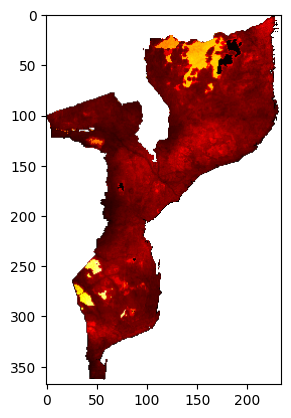

In [6]:
plt.imshow(beta_map, cmap="hot")

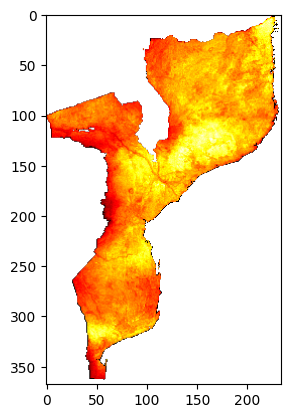

In [7]:
plt.imshow(prevalence, cmap="hot")

In [ ]:
pops = np.asarray(list(new_map[0.451].keys())).squeeze()

In [ ]:
pops[0]

In [ ]:
a, b, c = new_map[0.451][10]

In [ ]:
calibrate.get_beta(new_map, 0.451, 4234, 0.5)

In [ ]:
coefs = new_map[0.451][0]

In [ ]:
populations_ = np.asarray(list(new_map[0.451].keys())).squeeze()
populations_

In [ ]:
np.argwhere(populations_ <= 1010).squeeze().tolist()[-1]